# Globals

In [ ]:
root_path = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/"
path_pesi_old = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/pesi/pesi.h5"
history_saving_path_json = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/history.json"
save_checkpoints_path = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt"
path_root = "/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs"

In [ ]:
class_index = {'Adialer.C': 0,
              'Agent.FYI': 1,
              'Allaple.A': 2,
              'Allaple.L': 3,
              'Alueron.gen!J': 4,
              'Autorun.K': 5,
              'Benign': 6,
              'C2LOP.P': 7,
              'C2LOP.gen!g': 8,
              'Dialplatform.B': 9,
              'Dontovo.A': 10,
              'Fakerean': 11,
              'Instantaccess': 12,
              'Lolyda.AA1': 13,
              'Lolyda.AA2': 14,
              'Lolyda.AA3': 15,
              'Lolyda.AT': 16,
              'Malex.gen!J': 17,
              'Obfuscator.AD': 18,
              'Rbot!gen': 19,
              'Skintrim.N': 20,
              'Swizzor.gen!E': 21,
              'Swizzor.gen!I': 22,
              'VB.AT': 23,
              'Wintrim.BX': 24,
              'Yuner.A': 25}

# Setting up the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
train_df_partial=pd.read_csv(os.path.join(path_root,"train_combined3.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_combined3.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_combined3.csv"))


train_df =pd.concat([train_df_partial, val_df], ignore_index = True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 8268 validated image filenames belonging to 26 classes.
Found 2054 validated image filenames belonging to 26 classes.


In [ ]:
classes = train_gen.class_indices

# Analysis of class distribution for each subset

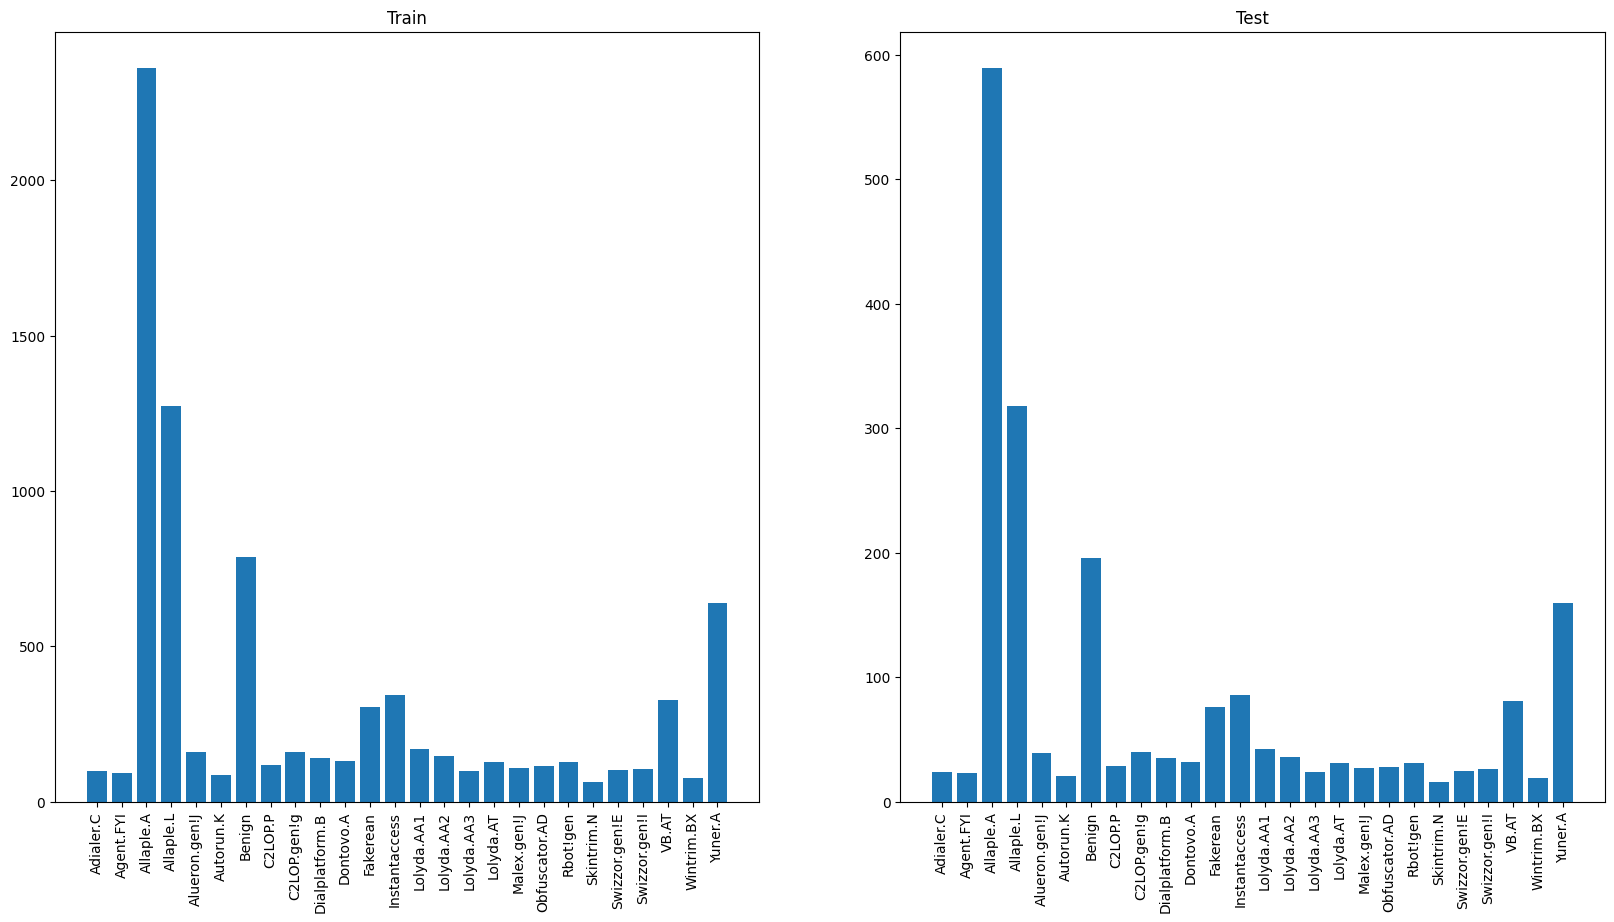

In [ ]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ]
name = ["Train", "Test"]

plt.figure(figsize = (20,10))

for i in range(2):

  plt.subplot(1,2,i+1)
  plt.title(name[i])
  plt.xticks(rotation = "vertical")
  plt.bar(classes.keys(), occur[i])

plt.show()

# Class weight calculation

In [ ]:
train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 3.2448979591836733,
 1: 3.4193548387096775,
 2: 0.13474576271186442,
 3: 0.2498036135113904,
 4: 2.0,
 5: 3.7411764705882353,
 6: 0.4040660736975858,
 7: 2.717948717948718,
 8: 1.9875,
 9: 2.23943661971831,
 10: 2.4461538461538463,
 11: 1.042622950819672,
 12: 0.9217391304347826,
 13: 1.8596491228070176,
 14: 2.1486486486486487,
 15: 3.212121212121212,
 16: 2.484375,
 17: 2.9174311926605503,
 18: 2.789473684210526,
 19: 2.5039370078740157,
 20: 4.96875,
 21: 3.087378640776699,
 22: 3.0,
 23: 0.9724770642201835,
 24: 4.076923076923077,
 25: 0.496875}

<BarContainer object of 26 artists>

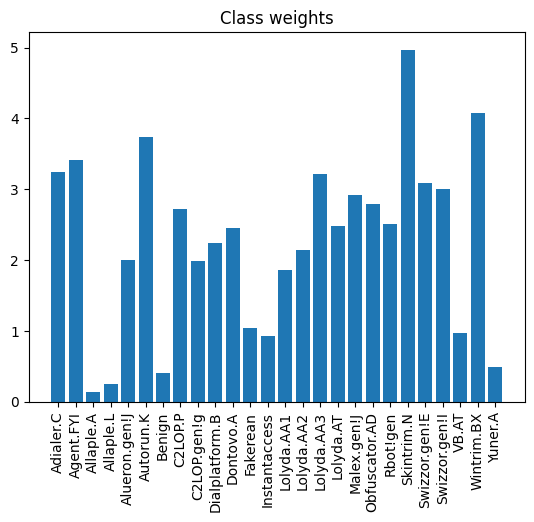

In [ ]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

# Building the CNN

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [ ]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

In [ ]:
Malware_model = malware_model()
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [ ]:
cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")

In [ ]:
#Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

# Training

In [ ]:
history = Malware_model.fit(train_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
259/259 [==============================] - ETA: 0s - loss: 2.5583 - accuracy: 0.1946 - weighted_accuracy: 0.2623 
Epoch 1: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 5758s 22s/step - loss: 2.5583 - accuracy: 0.1946 - weighted_accuracy: 0.2623
Epoch 2/10
259/259 [==============================] - ETA: 0s - loss: 1.1822 - accuracy: 0.5537 - weighted_accuracy: 0.6345
Epoch 2: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 46s 175ms/step - loss: 1.1822 - accuracy: 0.5537 - weighted_accuracy: 0.6345
Epoch 3/10
259/259 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.7234 - weighted_accuracy: 0.7468
Epoch 3: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 46s 178ms/step - loss: 0.7599 - accuracy: 0.7234 - weighted_accuracy: 0.7468
Epoch 4/10
259/259 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.7883 - weighted_accuracy: 0.7956
Epoch 4: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 46s 179ms/step - loss: 0.5914 - accuracy: 0.7883 - weighted_accuracy: 0.7956
Epoch 5/10
259/259 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.8120 - weighted_accuracy: 0.8106
Epoch 5: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 45s 175ms/step - loss: 0.5283 - accuracy: 0.8120 - weighted_accuracy: 0.8106
Epoch 6/10
259/259 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8367 - weighted_accuracy: 0.8361
Epoch 6: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 45s 171ms/step - loss: 0.4300 - accuracy: 0.8367 - weighted_accuracy: 0.8361
Epoch 7/10
259/259 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8402 - weighted_accuracy: 0.8498
Epoch 7: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 44s 171ms/step - loss: 0.4048 - accuracy: 0.8402 - weighted_accuracy: 0.8498
Epoch 8/10
259/259 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8728 - weighted_accuracy: 0.8551
Epoch 8: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 45s 172ms/step - loss: 0.3560 - accuracy: 0.8728 - weighted_accuracy: 0.8551
Epoch 9/10
259/259 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8787 - weighted_accuracy: 0.8681
Epoch 9: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 46s 176ms/step - loss: 0.3245 - accuracy: 0.8787 - weighted_accuracy: 0.8681
Epoch 10/10
259/259 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8919 - weighted_accuracy: 0.8773
Epoch 10: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt


259/259 [==============================] - 45s 173ms/step - loss: 0.3082 - accuracy: 0.8919 - weighted_accuracy: 0.8773


## History saving

In [ ]:
hist_df = pd.DataFrame(history.history)
with open(history_saving_path_json, 'wb') as file_pi:
    hist_df.to_json(file_pi)

## Model training plots

dict_keys(['loss', 'accuracy', 'weighted_accuracy'])


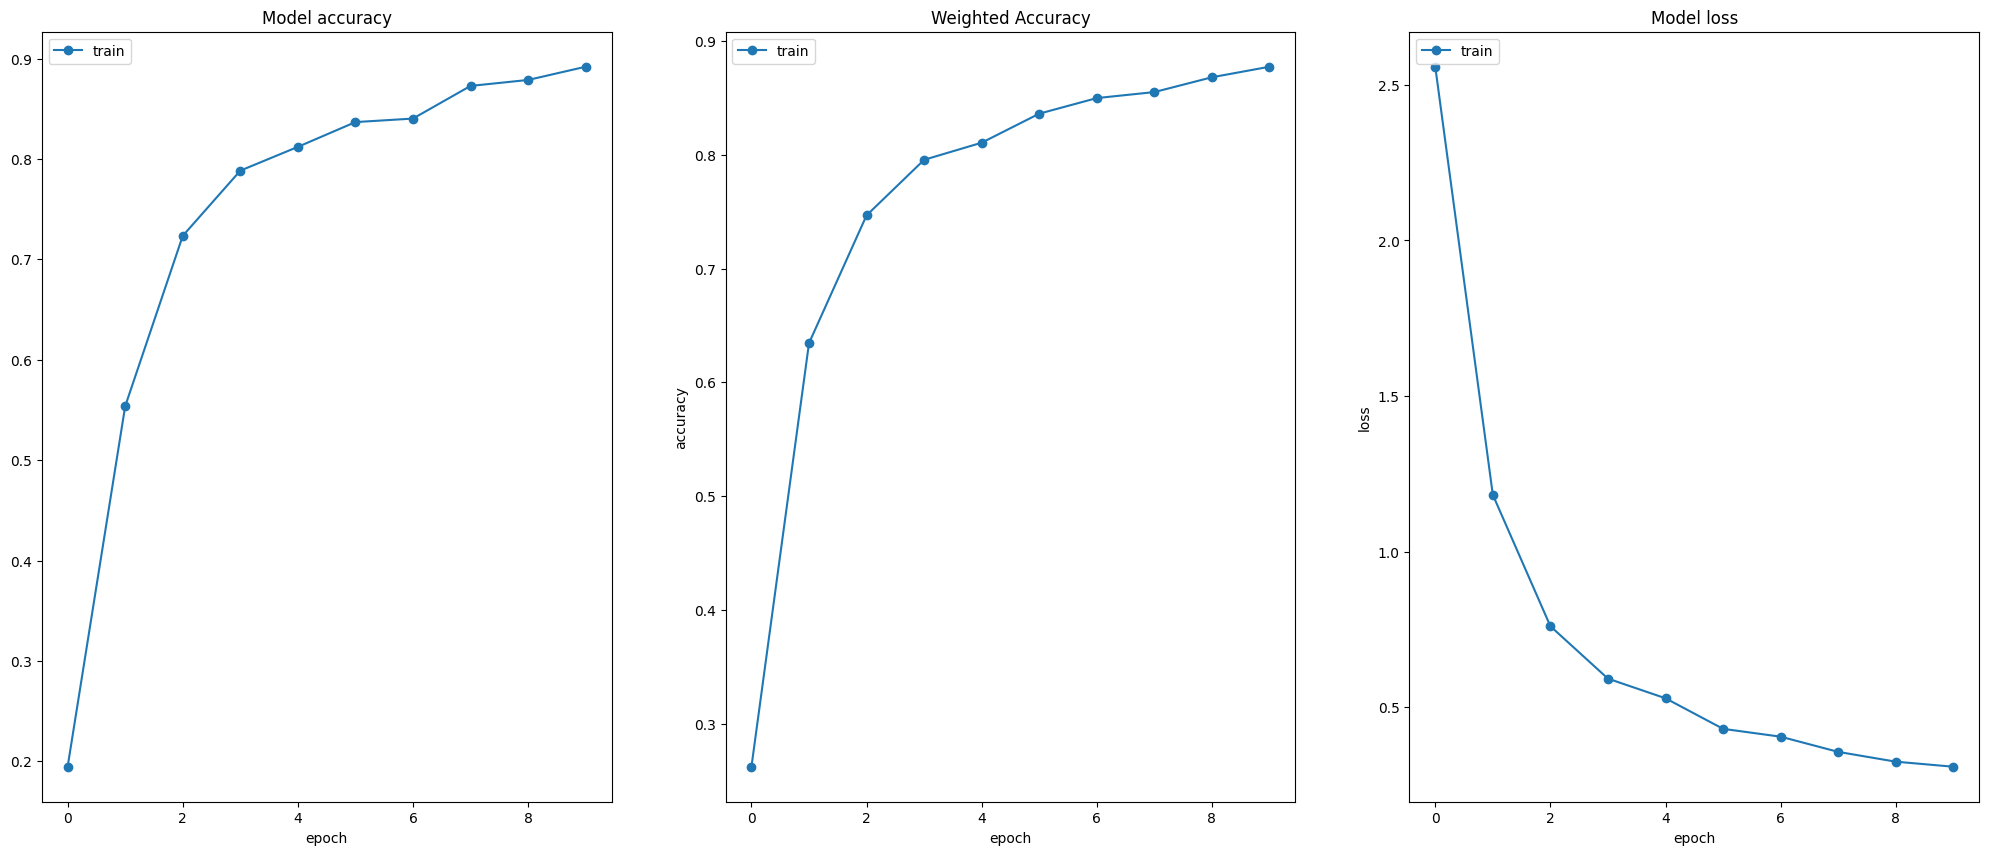

In [ ]:
print(history.history.keys())
plt.figure(figsize = (25,10))
#  "Accuracy"
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1,3,2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Results on Test Set

In [ ]:
metric_list = Malware_model.evaluate(test_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

65/65 [==============================] - 1413s 22s/step - loss: 0.3141 - accuracy: 0.8666 - weighted_accuracy: 0.8666
evaluate_accuracy=0.867
evaluate_weighted_accuracy=0.867


## Confusion matrix

In [ ]:
y_pred = Malware_model.predict(test_gen)
y_test_predicted = np.argmax(np.array(y_pred),axis = 1)

65/65 [==============================] - 9s 138ms/step


In [ ]:
from sklearn import metrics

In [ ]:
c_matrix = metrics.confusion_matrix(test_gen.classes, y_test_predicted)
df_confusion = pd.crosstab(test_gen.classes, y_test_predicted)
df_confusion.to_csv(os.path.join(root_path,"confusion_matrix.csv"))

In [ ]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

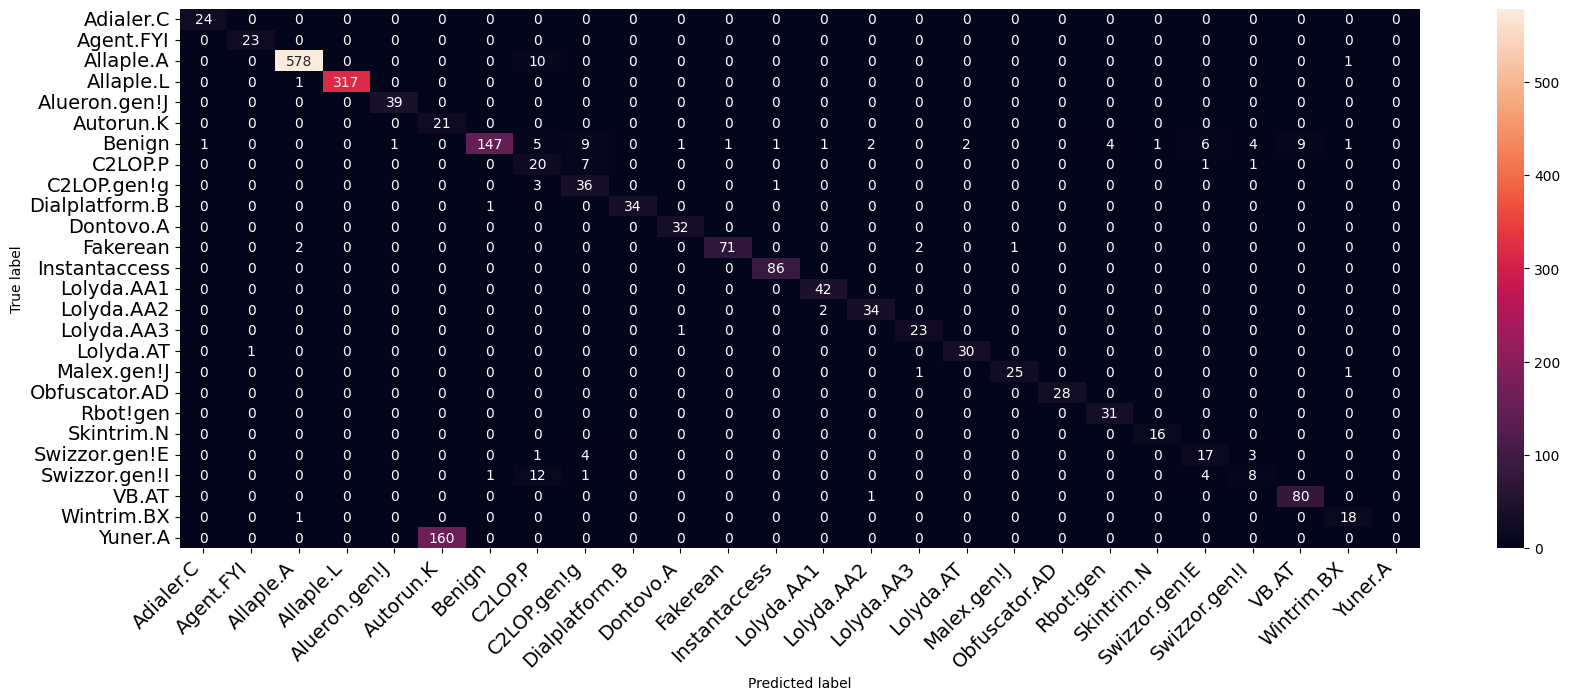

In [ ]:
confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [ ]:
report = metrics.classification_report(test_gen.classes, y_test_predicted, target_names=classes,  output_dict=True)
print(report)

{'Adialer.C': {'precision': 0.96, 'recall': 1.0, 'f1-score': 0.9795918367346939, 'support': 24}, 'Agent.FYI': {'precision': 0.9583333333333334, 'recall': 1.0, 'f1-score': 0.9787234042553191, 'support': 23}, 'Allaple.A': {'precision': 0.993127147766323, 'recall': 0.9813242784380306, 'f1-score': 0.9871904355251921, 'support': 589}, 'Allaple.L': {'precision': 1.0, 'recall': 0.9968553459119497, 'f1-score': 0.9984251968503937, 'support': 318}, 'Alueron.gen!J': {'precision': 0.975, 'recall': 1.0, 'f1-score': 0.9873417721518987, 'support': 39}, 'Autorun.K': {'precision': 0.11602209944751381, 'recall': 1.0, 'f1-score': 0.2079207920792079, 'support': 21}, 'Benign': {'precision': 0.9865771812080537, 'recall': 0.75, 'f1-score': 0.8521739130434783, 'support': 196}, 'C2LOP.P': {'precision': 0.39215686274509803, 'recall': 0.6896551724137931, 'f1-score': 0.5, 'support': 29}, 'C2LOP.gen!g': {'precision': 0.631578947368421, 'recall': 0.9, 'f1-score': 0.7422680412371133, 'support': 40}, 'Dialplatform.B'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round({'precision': 5, 'recall': 5, 'f1-score': 5})
df_report.to_csv(os.path.join(root_path,"report.csv"))